# Objecif

Utiliser trackpy de manière intelligente.

Je suis le tutoriel ici: https://soft-matter.github.io/trackpy/v0.3.2/tutorial/walkthrough.html

In [12]:
import os

import matplotlib.pyplot as plt

import trackpy
import pims

plt.rcParams['savefig.dpi'] = 120
plt.rcParams['figure.dpi'] = 120

## Loading

In [4]:
DATA = "/Users/benjaminhabert/Documents/FluotrackerProject/fluotracker/data/"
filename = "raw/movie8.tif"
file_path = os.path.join(DATA, filename)

Frame([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0, 10],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)
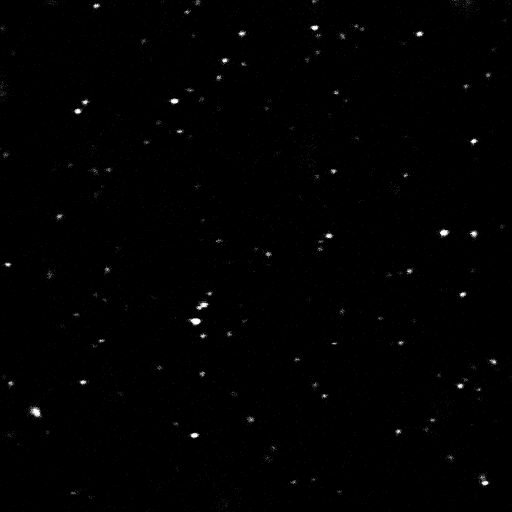

In [13]:
frames = pims.TiffStack(file_path)
frames[0]

## Extracting positions

In [18]:
parameters = {
    'diameter': 11,  # px
    'minmass': 50
}

In [35]:
located_blobs = trackpy.batch(frames, parameters['diameter'], minmass=parameters['minmass'])
located_blobs.head()

Frame 230: 136 features


,x,y,mass,size,ecc,signal,raw_mass,ep,frame
0,95.957811,5.436973,3534.562577,2.336989,0.191408,175.327318,4166.0,0.002518,0
1,186.648058,11.582524,1489.378452,2.150863,0.160203,92.182404,1862.0,0.005637,0
2,504.250000,20.074219,231.359760,2.147855,0.187626,16.267483,269.0,0.039179,0
3,314.241947,27.291667,5162.214636,2.433427,0.213795,216.899775,6324.0,0.001659,0
4,360.524506,27.917455,1051.060158,2.837381,0.347323,53.321195,1263.0,0.008313,0


### Investigating position extraction

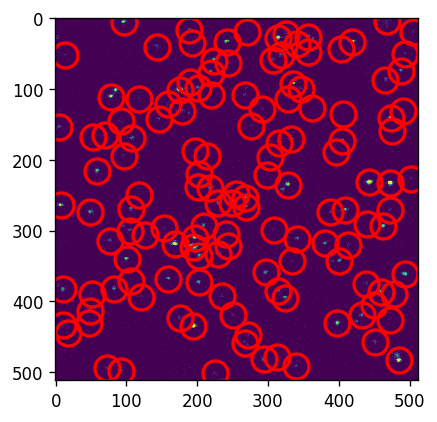

In [36]:
frame_number = 10
centroids = located_blobs.loc[located_blobs['frame'] == frame_number]
frame = frames[frame_number]
trackpy.annotate(centroids, frame, imshow_style={'cmap': 'viridis'})

In [37]:
# nombre de points par frame
n_blobs = located_blobs.groupby('frame').size()
n_blobs.head()

frame
0    147
1    144
2    144
3    140
4    147
dtype: int64

Text(0,0.5,'Number of blobs')

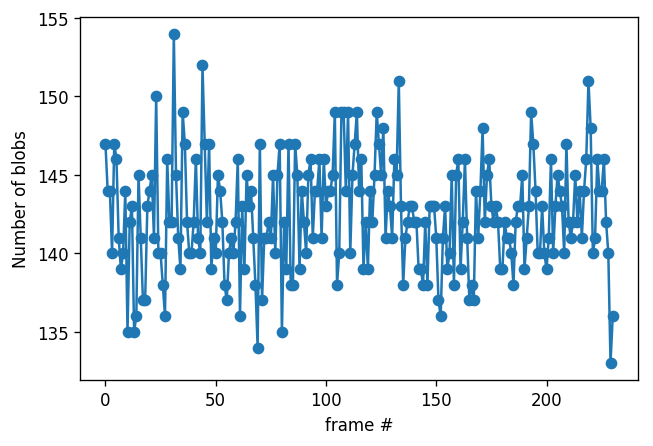

In [38]:
plt.plot(n_blobs, '-o')
plt.xlabel('frame #')
plt.ylabel('Number of blobs')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117387be0>,
      dtype=object)

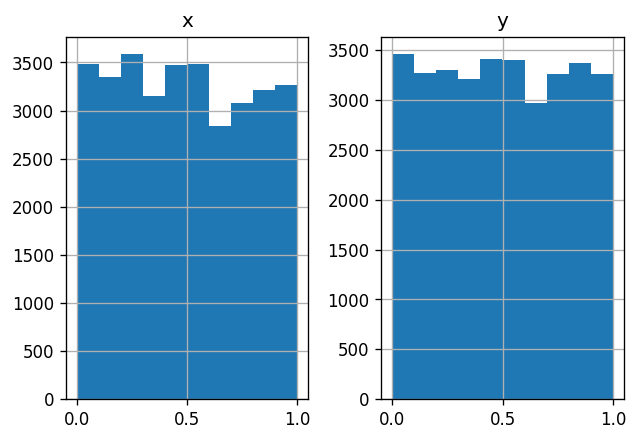

In [39]:
trackpy.subpx_bias(located_blobs)

In [41]:
parameters = {
    "search_range": 10,
    "memory": 5
}

In [43]:
tracks = trackpy.link_df(located_blobs, **parameters)
tracks.head()

Frame 230: 136 trajectories present


,x,y,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,95.957811,5.436973,3534.562577,2.336989,0.191408,175.327318,4166.0,0.002518,0,0.0
1,96.128755,5.646068,4681.906459,2.406428,0.115009,209.597496,5601.0,0.001922,1,0.0
2,95.829487,5.225962,2822.231724,2.210914,0.176837,157.393692,3312.0,0.003509,2,0.0
3,95.738720,5.173662,3426.047979,2.285154,0.147961,179.750681,4023.0,0.002689,3,0.0
4,96.121591,5.296118,2821.190012,2.236857,0.182520,164.727809,3348.0,0.003169,4,0.0


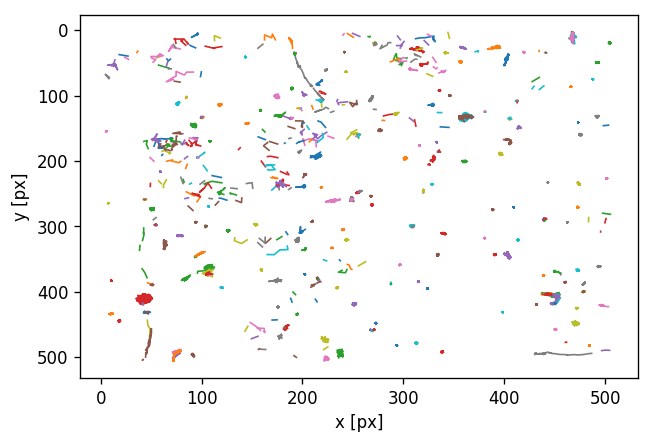

In [44]:
trackpy.plot_traj(tracks)

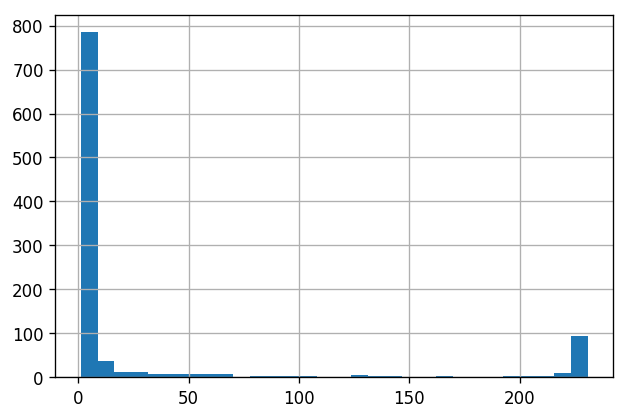

In [58]:
tracks.groupby('particle').size().hist(bins=30)

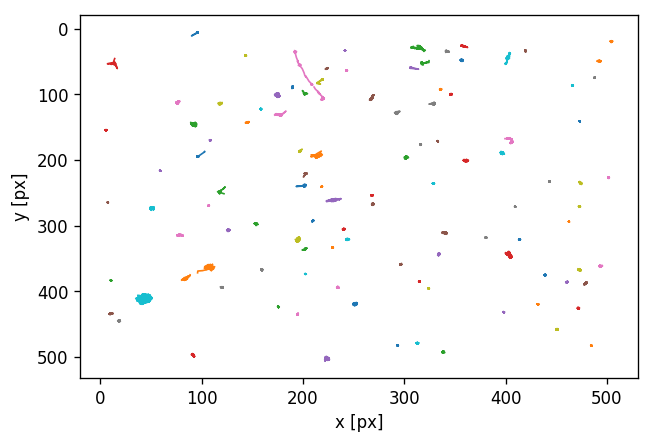

In [64]:
filtered = trackpy.filter_stubs(tracks, threshold=200)
trackpy.plot_traj(filtered)

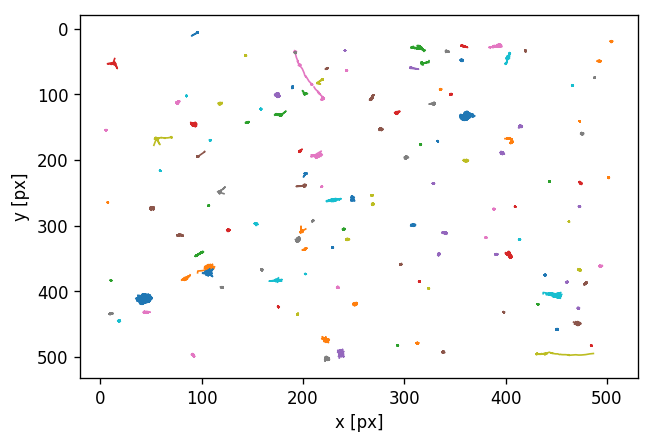

In [65]:
filtered = trackpy.filter_stubs(tracks, threshold=100)
trackpy.plot_traj(filtered)

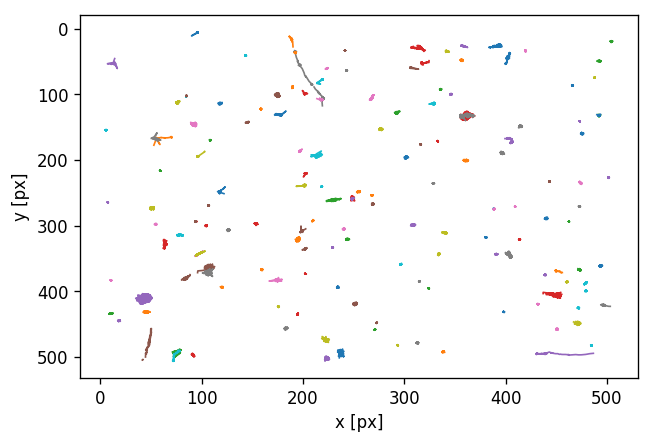

In [132]:
filtered = trackpy.filter_stubs(tracks, threshold=50)
trackpy.plot_traj(filtered)

Text(0.5,0,'Size in px')

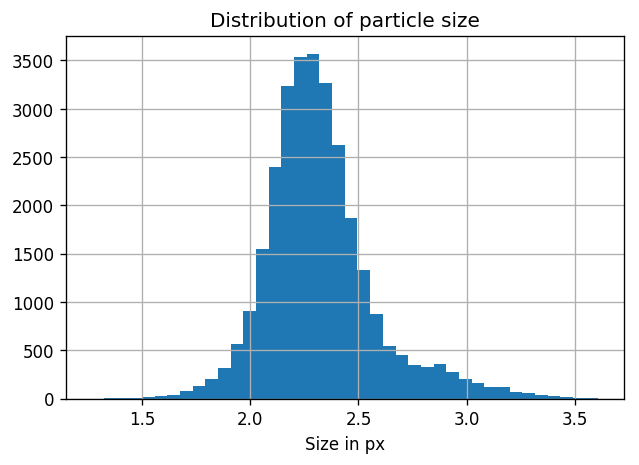

In [133]:
filtered['size'].hist(bins=40)
plt.title('Distribution of particle size')
plt.xlabel('Size in px')

In [134]:
drift = trackpy.compute_drift(filtered)
drift.head()

,x,y
frame,,
1,-0.055456,0.074215
2,0.080143,0.058169
3,-0.027646,0.022657
4,-0.057297,0.124684
5,0.086306,0.052458


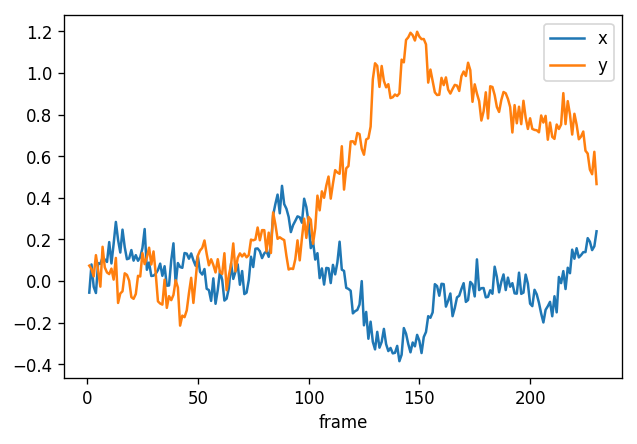

In [135]:
drift.plot()

In [136]:
diagonals = filtered.groupby('particle').apply(trackpy.diagonal_size).sort_values(ascending=False)
diagonals.head()

particle
7.0      81.002704
537.0    56.895890
415.0    50.891753
112.0    40.703822
50.0     24.009253
dtype: float64

Text(0,0.5,'Number of particles')

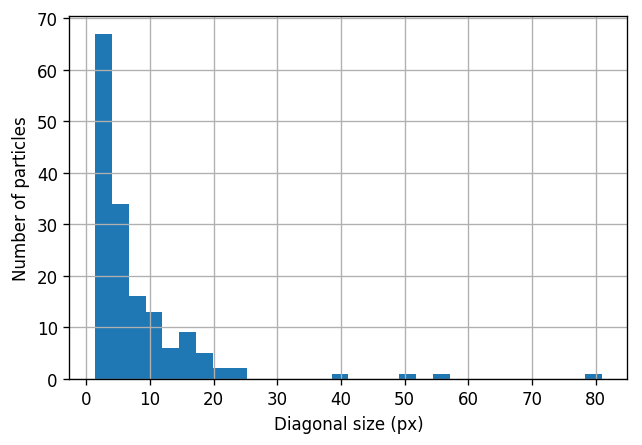

In [137]:
diagonals.hist(bins=30)
plt.xlabel('Diagonal size (px)')
plt.ylabel('Number of particles')

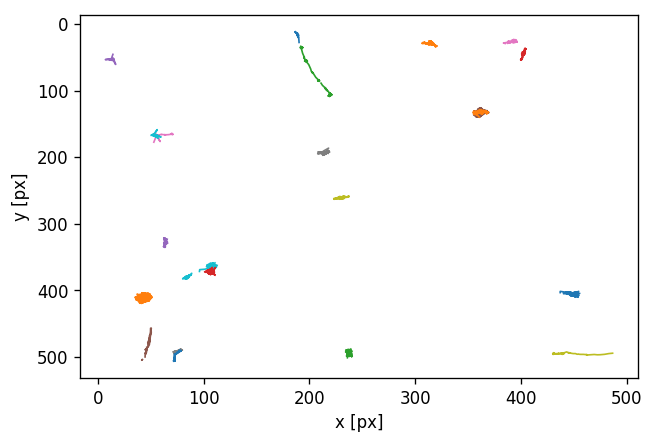

In [138]:
t = filtered.groupby('particle').filter(lambda s: trackpy.diagonal_size(s) > 15)
trackpy.plot_traj(t)

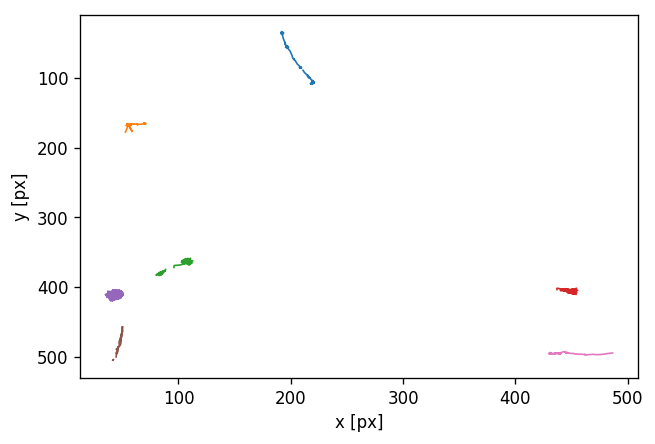

In [141]:
t = filtered.groupby('particle').filter(lambda s: trackpy.diagonal_size(s) > 20)
trackpy.plot_traj(t)

(189.88868144291646, 222.57780472391642, 29.75886286173913, 112.6489178929582)

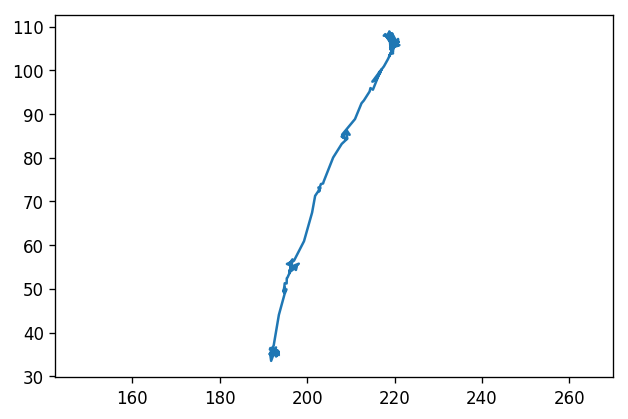

In [271]:
particle = diagonals.index[0]
particle_track = filtered.loc[filtered['particle'] == particle]
plt.plot(particle_track['x'], particle_track['y'])
plt.axis('equal')

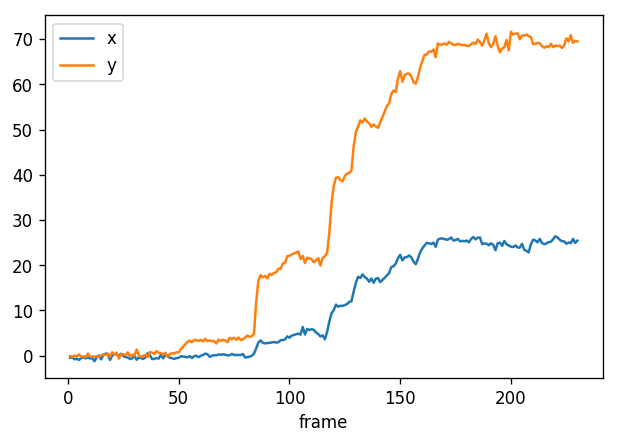

In [272]:
particle_drift = trackpy.compute_drift(particle_track)
particle_drift.plot()

(-2.5950404376036875,
 27.797369590980864,
 -4.240646757663534,
 75.25721188751501)

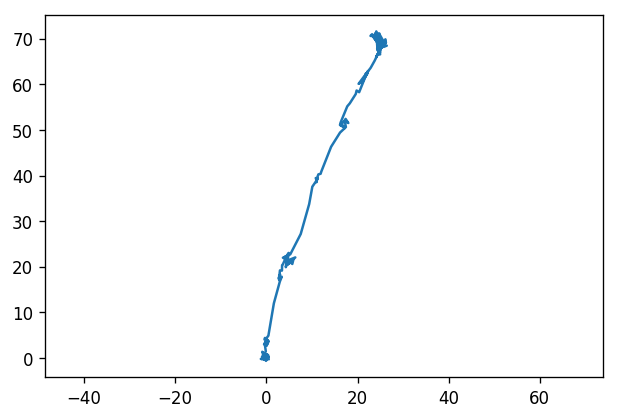

In [273]:
plt.plot(particle_drift['x'], particle_drift['y'])
plt.axis('equal')

In [274]:
subtracted = trackpy.subtract_drift(particle_track.copy(), particle_drift)
subtracted.head()

,x,y,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
0,192.995902,35.141393,441.029542,2.181799,0.044173,30.727468,493.0,0.021331,0,7.0
1,192.995902,35.141393,386.949223,2.011541,0.137226,31.350053,415.0,0.026018,1,7.0
2,192.995902,35.141393,342.828790,2.474674,0.049672,17.186668,385.0,0.030282,2,7.0
3,192.995902,35.141393,277.714802,1.897878,0.248289,20.671328,309.0,0.035149,3,7.0
4,192.995902,35.141393,348.462674,2.206837,0.176518,24.437642,381.0,0.027929,4,7.0


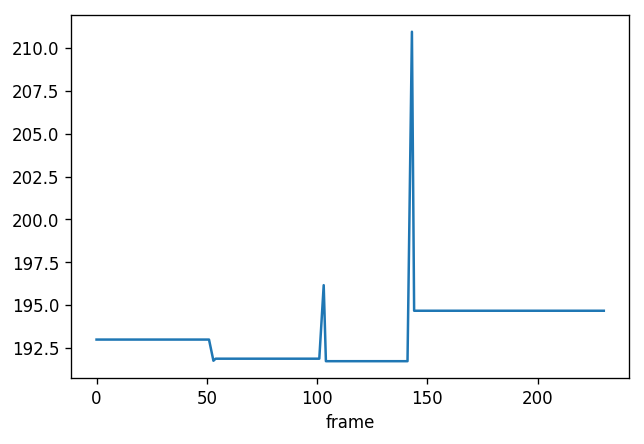

In [275]:
subtracted['x'].plot()

# Trouver la trajectoire d'une particule

On veut décomposer le mouvement en:
    
- un déplacement le long d'une line (avec des stops)
- un mouvement aléatoire

Méthode:

1. Je trouve une parabolle qui reproduit grosso modo la trajectoire
2. je cherche la projection de chaque point sur la parabolle (https://stackoverflow.com/questions/19101864/find-minimum-distance-from-point-to-complicated-curve)
3. je calcule s en fonction du temps

In [276]:
from scipy import optimize
def f(x, a, b, c, d):
    return a + b * x + c * (x**2) + d * (x ** 3) 
params, cov = optimize.curve_fit(f, particle_track['x'], particle_track['y'])
optimized_f = lambda x: f(x, *params)

(189.88868144291646, 222.57780472391642, 27.52161715589674, 112.75545340276022)

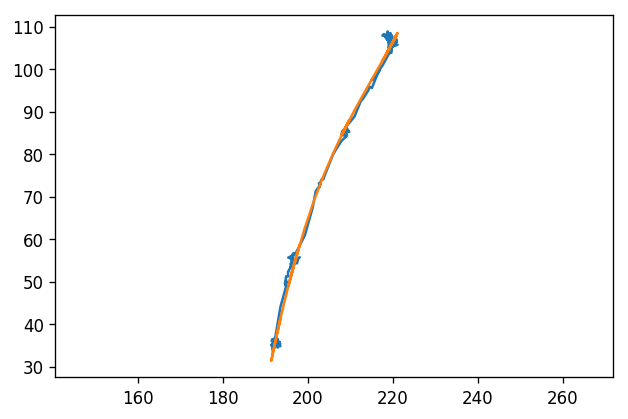

In [277]:
plt.plot(particle_track['x'], particle_track['y'])
plt.plot(particle_track['x'], optimized_f(particle_track['x']))
plt.axis('equal')

In [278]:
from shapely import geometry as geom

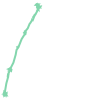

In [279]:
real_line = geom.LineString([(x, y) for x, y in particle_track.loc[:, ['x', 'y']].values])
real_line

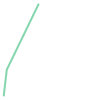

In [283]:
real_line.simplify(tolerance=3)

In [284]:
# creating a line with many point for interpolation
coordinates = [
    (x, optimized_f(x))
    for x in pd.np.linspace(particle_track['x'].min(), particle_track['x'].max(), 10000)
]
line = geom.LineString(coordinates)

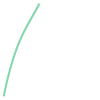

In [285]:
line

In [286]:
import pandas as pd
def project_on_line(line, xs, ys):
    distance_along_line = []
    distance_from_line = []
    dx = []
    dy = []
    for x, y in zip(xs, ys):
        point = geom.Point(x, y)
        distance_along = line.project(point)
        distance_along_line.append(distance_along)
        distance_from_line.append(line.distance(point))
        point_projected_on_line = line.interpolate(distance_along)
        dx.append(point.x - point_projected_on_line.x)
        dy.append(point.y - point_projected_on_line.y)
    return pd.DataFrame({
        'distance_along_line': distance_along_line,
        'distance_from_line': distance_from_line,
        'dx': dx,
        'dy': dy
    })
projected = project_on_line(line, particle_track['x'], particle_track['y'])

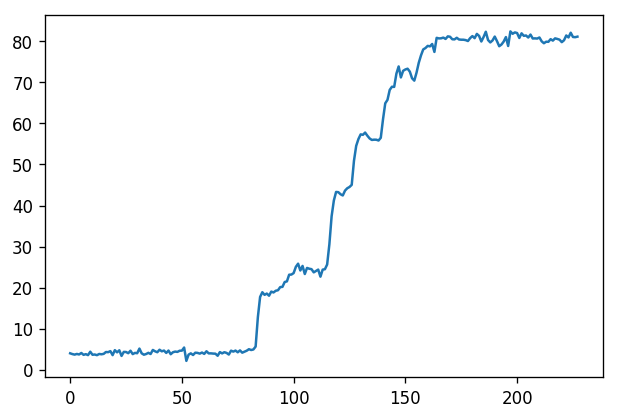

In [287]:
projected['distance_along_line'].plot()

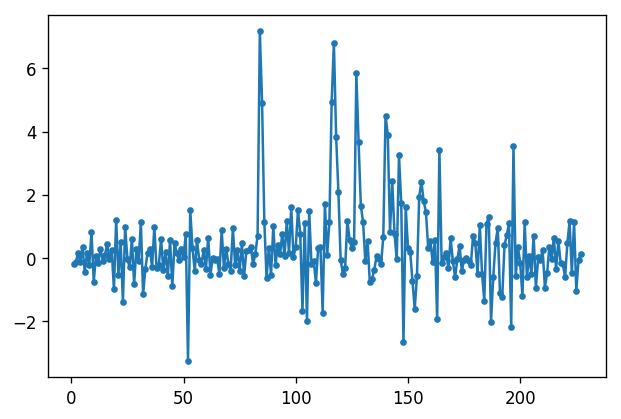

In [288]:
projected['distance_along_line'].diff().plot(style='.-')

# infos sur le déplacement

La vitesse de déplacement semble atteindre (pix = 0.17 um, frame = 0.52877 secondes)

- 6 pixel / frame
- 1 micron / frame
- 1.9 micron / seconde

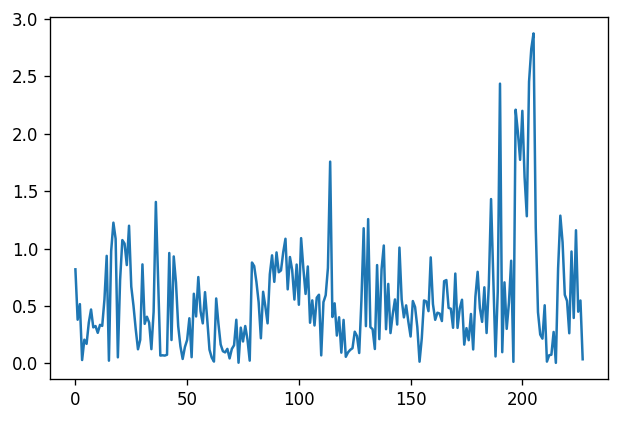

In [289]:
projected['distance_from_line'].plot()

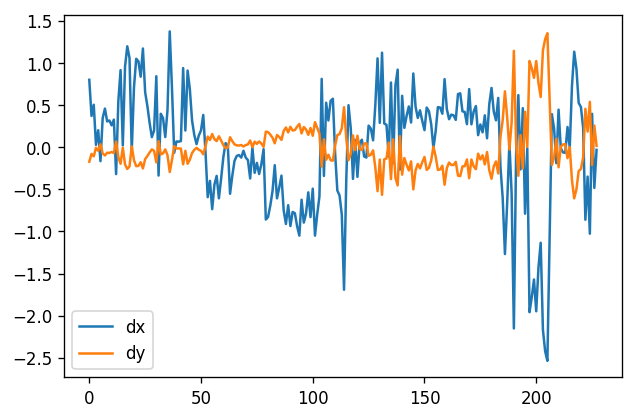

In [290]:
projected[['dx', 'dy']].plot()